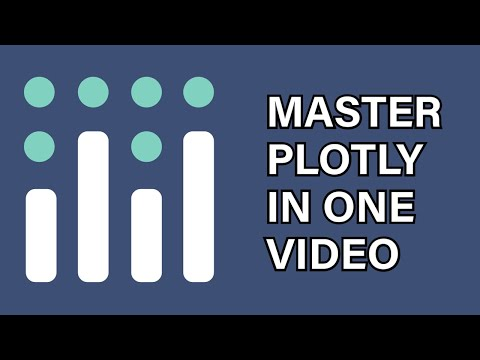

In [1]:
# Derek Banas "Plotly Tutorial 2020", eng

from IPython.display import YouTubeVideo
YouTubeVideo('GGL6U0k8WYA', width=900, height=500)

---

# The goal of the project
## Invesigate the current conditions on market establishments in Los Angeles aiming to detect the  most profitable location and type of establishment for a new robot cafe.  We will present the results of our research in presentation form to attach investors.

* [Step 1. Download the data and prepare it for analysis](#1)
    * [Conclusion](#1_1)
* [Step 2. Data analysis](#2)
    * [2.1. Investigate the proportions of the various types of establishments](#2_1)
    * [2.2. Investigate the proportions of chain and nonchain establishments](#2_2)
    * [2.3. Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats?](#2_3)
    * [2.4. Put the data on street names from the address column in a separate column.Plot a graph of the top ten streets by number of restaurants. Find the number of streets that only have one restaurant.](#2_4)
    * [2.5. For streets with a lot of restaurants, look at the distribution of the number of seats. What trends can you see?](#2_5)
    * [2.6. Conclusion. Draw an overall conclusion and provide recommendations on restaurant type and number of seats. Comment on the possibility of developing a chain.](#2_6)
* [Step 3. Preparing a presentation](#3)

### Step 1. Download the data and prepare it for analysis

In [2]:
! pip install usaddress

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 63 kB 776 kB/s eta 0:00:01
     |████████████████████████████████| 743 kB 2.6 MB/s eta 0:00:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import math
import datetime as dt
from scipy import stats as stats
import plotly.graph_objects as go
import plotly.express as px
import warnings
import usaddress
import copy

warnings.filterwarnings('ignore')

In [4]:
rest_data = pd.read_csv('/datasets/rest_data_us.csv', sep=',')
display(rest_data.head())
display(rest_data.tail())
display(rest_data.describe(include='object'))
display(rest_data.info())

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


,id,object_name,address,chain,object_type,number
9646,21432,HALL OF JUSTICE,217 W TEMPLE AVE,False,Restaurant,122
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93
9648,21434,JUICY WINGZ,6741 HOLLYWOOD BLVD,True,Fast Food,15
9649,21435,MEDIDATE COFFEE,548 S SPRING ST STE 100,False,Cafe,6
9650,21436,CAFE SPROUTS,1300 S SAN PEDRO ST STE 111,True,Restaurant,19


,object_name,address,chain,object_type
count,9651,9651,9648,9651
unique,8672,8517,2,6
top,THE COFFEE BEAN & TEA LEAF,3607 TROUSDALE PKWY,False,Restaurant
freq,47,11,5972,7255


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
id             9651 non-null int64
object_name    9651 non-null object
address        9651 non-null object
chain          9648 non-null object
object_type    9651 non-null object
number         9651 non-null int64
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


None

In [5]:
rest_data.dropna(subset=['chain'], inplace=True)
rest_data['chain'] = rest_data['chain'].astype('bool')

On this stage I decided to add a street column for further analysis, as well as for more correct work with duplicates.

In [6]:
def cleaning_check(raw):
    raw_address=usaddress.parse(raw)
    dict_address={}
    for i in raw_address:
        dict_address.update({i[1]:i[0]})
    if 'StreetName' in dict_address.keys() and 'AddressNumber' in dict_address.keys():
        clean_adress=dict_address['AddressNumber']+","+str(dict_address['StreetName'])
        return clean_adress
    else:
        return 'no street or number'

In [7]:
rest_data['clean_street_check'] = rest_data.address.apply(cleaning_check)
display(rest_data[rest_data['clean_street_check']=='no street or number'])
display(usaddress.parse(rest_data.iloc[1888]['address']))

,id,object_name,address,chain,object_type,number,clean_street_check
1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,no street or number
3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,no street or number
7003,18789,D.K. DONUTS,1033 1/2 LOS ANGELES ST,False,Fast Food,8,no street or number
7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,no street or number
7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,no street or number
7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,no street or number
7327,19113,LA NOCHE BUENA,OLVERA ST E8,False,Restaurant,1,no street or number
7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,no street or number
7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,no street or number


[('OLVERA', 'PlaceName'), ('ST', 'StateName'), ('E17', 'ZipCode')]

In [8]:
def cleaning_final(raw):
    if raw.startswith('OLVERA'):
        clean_adress='OLVERA,Los Angeles,USA'
    elif raw.startswith('1033 1/2 LOS ANGELES'):
        clean_adress='1033 1/2 LOS ANGELES ST,Los Angeles,USA'
    else:
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_adress=dict_address['AddressNumber']+" "+str(dict_address['StreetName'])+str(', Los Angeles,USA')
    return clean_adress

In [9]:
rest_data['clean_street_final']=rest_data.address.apply(cleaning_final)
rest_data.sample(10)

,id,object_name,address,chain,object_type,number,clean_street_check,clean_street_final
5803,17589,PIZZA MAN,1578 COLORADO BLVD # 5,True,Pizza,23,"1578,COLORADO","1578 COLORADO, Los Angeles,USA"
4915,16701,RITA'S ICE-CUSTARD-HAPPINESS,11073 PICO BLVD,False,Restaurant,18,"11073,PICO","11073 PICO, Los Angeles,USA"
5234,17020,AMMO AT THE HAMMER,10899 WILSHIRE BLVD,False,Restaurant,33,"10899,WILSHIRE","10899 WILSHIRE, Los Angeles,USA"
8199,19985,LITTLE ONGPIN,5050 W SUNSET BLVD,False,Restaurant,16,"5050,SUNSET","5050 SUNSET, Los Angeles,USA"
2078,13864,SAGE VEGAN BISTRO,1700 W SUNSET BLVD,False,Restaurant,41,"1700,SUNSET","1700 SUNSET, Los Angeles,USA"
8714,20500,TOM'S JR EXRESS,724 W FLORENCE AVE,False,Restaurant,1,"724,FLORENCE","724 FLORENCE, Los Angeles,USA"
750,12536,CASA MONTEJO RESTAURANT,1125 W 6TH ST UNIT 105,True,Restaurant,23,"1125,6TH","1125 6TH, Los Angeles,USA"
4376,16162,YOU JUNG RESTAURANT,533 S WESTERN AVE # #C,True,Restaurant,64,"533,WESTERN","533 WESTERN, Los Angeles,USA"
4095,15881,JINGLE DONUTS,1901 S ALAMEDA ST STE 119,False,Fast Food,28,"1901,ALAMEDA","1901 ALAMEDA, Los Angeles,USA"
7253,19039,THE COFFEE BEAN & TEA LEAF,3726 S FIGUEROA ST,True,Cafe,24,"3726,FIGUEROA","3726 FIGUEROA, Los Angeles,USA"


In [10]:
def cleaning_tag(raw):
    try:
        if raw.startswith('OLVERA'):
            clean_adress='OLVERA,Los Angeles,USA'
        elif raw.startswith('1033 1/2 LOS ANGELES'):
            clean_adress='1033 1/2 LOS ANGELES ST,Los Angeles,USA'
        elif raw.startswith('3425 E 1ST ST SO. 3RDFL'):
            clean_adress='3425 E 1ST ST SO. 3RDFL'
        else:
            clean_adress=usaddress.tag(raw)[0]['StreetName']
    except:
        clean_adress='no street'
    return clean_adress

In [11]:
rest_data['clean_street_tag']=rest_data.address.apply(cleaning_tag)
rest_data.head()

,id,object_name,address,chain,object_type,number,clean_street_check,clean_street_final,clean_street_tag
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,"3708,ROCK","3708 ROCK, Los Angeles,USA",EAGLE ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,"100,WORLD","100 WORLD, Los Angeles,USA",WORLD
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,"6801,HOLLYWOOD","6801 HOLLYWOOD, Los Angeles,USA",HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,"1814,SUNSET","1814 SUNSET, Los Angeles,USA",SUNSET
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,"2100,PARK","2100 PARK, Los Angeles,USA",ECHO PARK


In [12]:
def regex_str_col(df, cols):
    for col in cols:
        df[col] = df[col].str.lower()
        df[col] = df[col].replace('[^a-zA-Z0-9 ]', '', regex=True)
    return df
cols = ['object_name', 'address', 'object_type', 'clean_street_tag']
rest_data = regex_str_col(rest_data, cols)
dups = rest_data[rest_data.duplicated(subset=['object_name','clean_street_final'])]
display(dups.shape[0])
rest_data = rest_data.drop_duplicates(subset=['object_name','clean_street_final'], keep='last')
rest_data.shape[0]

141

9507

#### Conclusion

At this stage, the data file on restaurants in LA was downloaded and stored into the DataFrame. From the received general information about the data we see that the DataFrame consists of 6 columns (of which 4 object type and 2 - int type) and 9651 rows.  I can conclude that the table looks good at first glance, it was necessary to change the data type of the chaun column and in the same column we see the missing values. The address column consists 8517 unique names, and the name column consists 8672 unique names, so I find it necessary to check the DataFrame for duplicates and delete them.

### Step 2. Data analysis

#### 2.1. Investigating the proportions of the various types of establishments

In [13]:
group_est = rest_data.groupby('object_type', as_index=False).agg({'id':'count'})
group_est.columns = ['object_type', 'count']
group_est = group_est.sort_values(by='count', ascending=False)
display(group_est)

,object_type,count
5,restaurant,7144
3,fast food,1052
2,cafe,430
4,pizza,309
1,bar,291
0,bakery,281


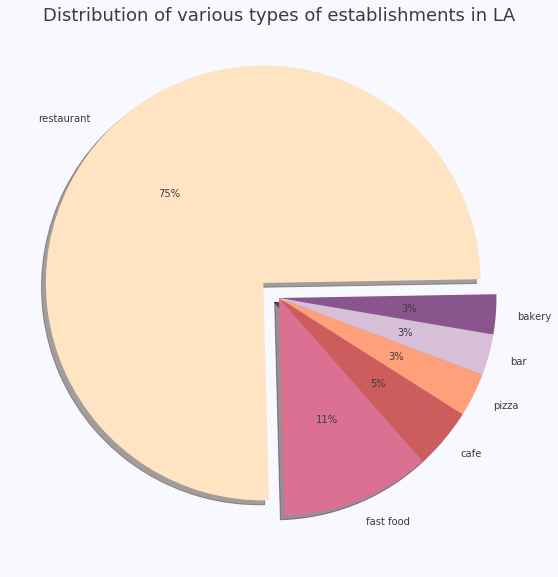

In [14]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor='GhostWhite')
font_color = '#3c3c3c'
colors = ['#FFE4C4', '#DB7093', '#CD5C5C', '#FFA07A', '#D8BFD8','#88558c']
explode = (0.1, 0, 0, 0, 0, 0)  
ax.pie(group_est['count'], labels=group_est['object_type'], colors=colors, explode=explode, autopct='%1.0f%%', shadow=True, startangle=True, textprops={'color':font_color})
ax.set_title('Distribution of various types of establishments in LA', fontsize=18, color=font_color)
plt.show()

In [15]:
filename = 'establishments'
plt.savefig(filename+'.png', facecolor=('#e8f4f0'))

<Figure size 432x288 with 0 Axes>

As we can conclude from the graph above, in LA the largest number of establishments are restaurants (75% of all establishments). 
In second place in terms of popularity is fast food (11%) and other types of establishments occupy from 3 to 4.5 %% in the share of all establishments of LA.
Based on this data, I can draw several conclusions and suggetions:
1. The LA market is oversaturated with restaurant type establishment.
2. This establishment is the most popular among visitors.
3. This type is the most profitable for establishment owners.
For more accurate conclusions we need to make a much deeper analysis of the market.
But in any case, the distribution of stablishments is already a good sign, since we plan to open a cafe, and we do not need much competition.

#### 2.2. Investigating the proportions of chain and nonchain establishments

In [16]:
chain_nonchain = rest_data.groupby('chain').agg({'id':'count'})
chain_nonchain.columns=['count']
chain_nonchain

,count
chain,
False,5957
True,3550


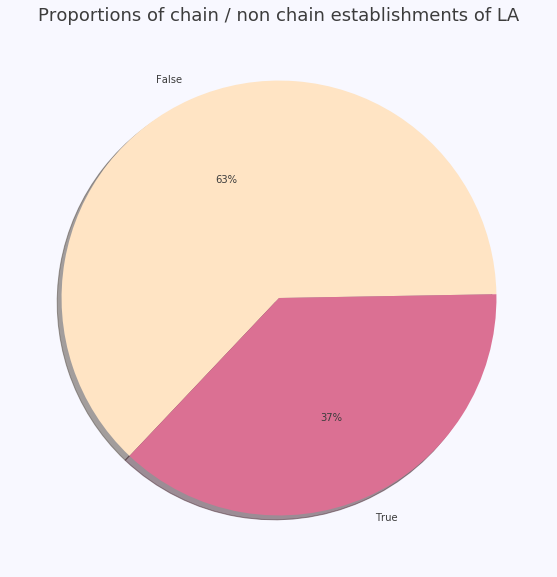

In [17]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor='GhostWhite')
font_color = '#3c3c3c'
colors = ['#FFE4C4', '#DB7093', '#CD5C5C', '#FFA07A', '#D8BFD8','#88558c']
ax.pie(chain_nonchain['count'], labels=chain_nonchain.index, colors=colors, autopct='%1.0f%%', shadow=True, startangle=True, textprops={'color':font_color})
ax.set_title('Proportions of chain / non chain establishments of LA', fontsize=18, color=font_color)
plt.show()

On the graph above we can see the proportion of chain and non chain establishments in LA. From all restaurants 63% are non chain establishments and 37% are chain.

In [18]:
est_chain_stat = rest_data.pivot_table(index='object_type', columns='chain', values='id', aggfunc='nunique')
est_chain_stat.columns = ['non_chain', 'chain']

est_chain_stat = est_chain_stat.fillna('0').astype(int)
est_chain_stat['chain_prop,%'] = est_chain_stat['chain']/(est_chain_stat['non_chain']+est_chain_stat['chain'])*100
display(est_chain_stat)

,non_chain,chain,"chain_prop,%"
object_type,,,
bakery,0,281,100.000000
bar,215,76,26.116838
cafe,168,262,60.930233
fast food,460,592,56.273764
pizza,166,143,46.278317
restaurant,4948,2196,30.739082


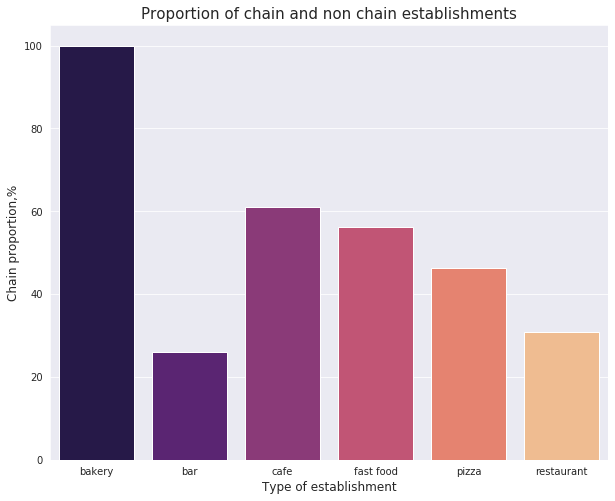

In [19]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
ax=sns.barplot(x=est_chain_stat.index, y='chain_prop,%', data = est_chain_stat, palette="magma")

plt.title('Proportion of chain and non chain establishments',fontdict={'size':15})    
plt.ylabel("Chain proportion,%",fontdict={'size':12})
plt.xlabel("Type of establishment",fontdict={'size':12})
plt.show()

As we can see from the diagramms above, the bakery establishments are typically a chain (all investigated bakeries are chain). Also we see, that 60% of cafe-type establishments, asa well as 56% of fast foods are also chain-type establishments, in a further study we will find out how this results turns out to be on the number of seats in these type establishments. As for restaurants, only 30% of this type are chain.


In [20]:
branches_grouped = rest_data.groupby(['object_name']).agg({'chain':'first', 'object_name':'count', 'number':'mean'})
branches_grouped.columns=['chain', 'count', 'seats']
branches_grouped

,chain,count,seats
object_name,,,
1 cafe,False,1,4.0
1 chinese fast food,True,1,6.0
1 donut,False,1,21.0
1 donuts,False,1,25.0
1 street poolbillard parlor,False,1,9.0
...,...,...,...
zulys 99 and up discount,False,1,10.0
zuma kitchen,False,1,98.0
zweet cafe,False,1,15.0


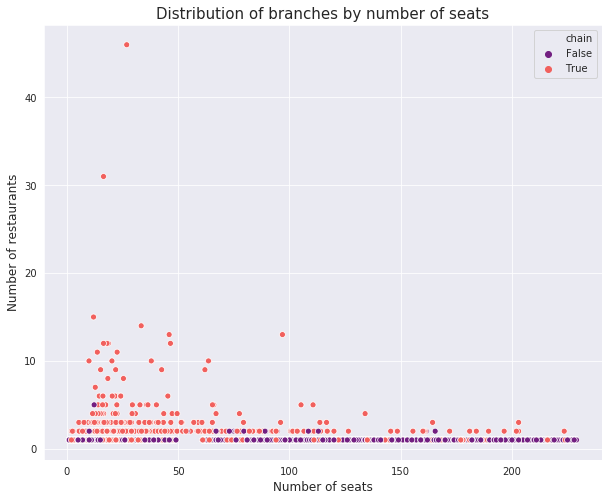

In [21]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

sns.scatterplot(data=branches_grouped, x='seats', y='count', hue='chain', palette="magma")

plt.title('Distribution of branches by number of seats',fontdict={'size':15})    
plt.ylabel("Number of restaurants",fontdict={'size':12})
plt.xlabel("Number of seats",fontdict={'size':12})
plt.show()

On the graph above we can see the distribution of branches by number of seats. We can conclude that more chain establishments have up to 50 seats in their restaurants. Only one chain with more than 10 establishments has more than seats. Also we see the maximum number of seats at non-chain establishments, or at chains that include 2-3 establishments.

#### 2.3. Determining the average number of seats for each type of restaurant.

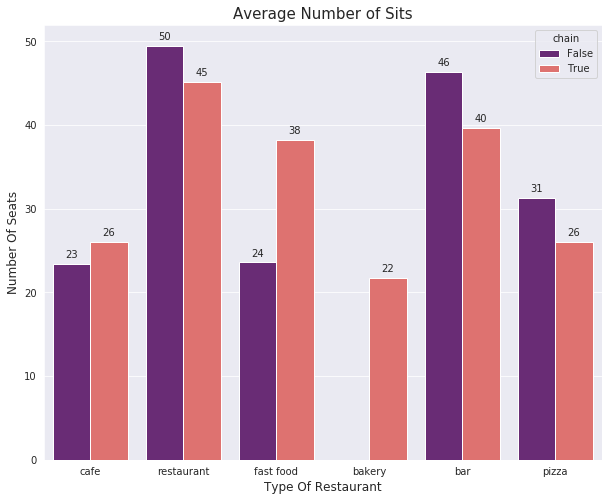

In [22]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
ax=sns.barplot(x=rest_data.object_type, y=rest_data.number,hue=rest_data.chain,palette="magma",ci=None)
for p in ax.patches:
    ax.annotate(format(p.get_height(),'.0f'),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.title('Average Number of Sits',fontdict={'size':15})    
plt.ylabel("Number Of Seats",fontdict={'size':12})
plt.xlabel("Type Of Restaurant",fontdict={'size':12})
plt.show()

On the graph above we examined the difference in the number of seats between chain and non chain establishments by type of establishment. On average, chain establishments provide 5 more seats than non-chain ones. 
The only exception is fast-food, were, on average, the number of seats in non-chain establishments is much higher.

#### 2.4. The most popular streets by number of restaurants and the streets that only have one restaurant.

In [23]:
top_streets = rest_data.groupby('clean_street_tag', as_index=False).agg({'id':'count'})
top_streets.columns = ['street', 'count']
top_streets = top_streets.sort_values(by='count', ascending=False)
top10 = top_streets.nlargest(10, 'count')
top10

,street,count
415,sunset,400
465,wilshire,392
357,pico,365
455,western,360
176,figueroa,327
339,olympic,304
439,vermont,283
387,santa monica,261
25,3rd,260
221,hollywood,252


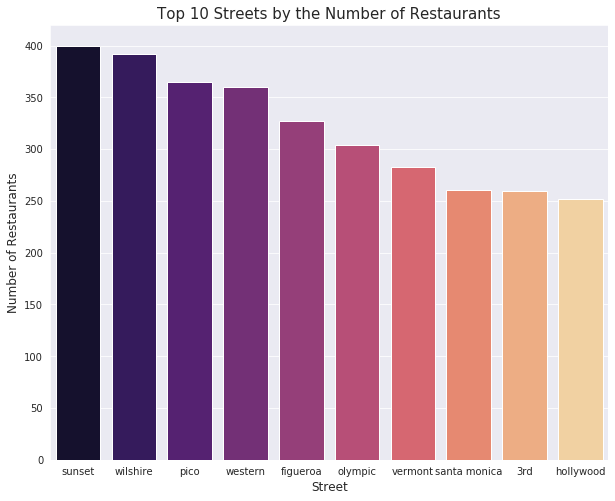

In [24]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
ax=sns.barplot(x='street', y='count', data = top10, palette="magma")

plt.title('Top 10 Streets by the Number of Restaurants',fontdict={'size':15})    
plt.ylabel("Number of Restaurants",fontdict={'size':12})
plt.xlabel("Street",fontdict={'size':12})
plt.show()

In [25]:
streets_one_rest = top_streets[top_streets['count'] == 1]
print('The number of streets in LA with only one restaurant is ', streets_one_rest.shape[0])

The number of streets in LA with only one restaurant is  195


From the investigation above we can conclude that the largest number of restaurants is on Sunset street, which is not surprising, it is one of the most popular walking streets LA with a rich nightlife.

Wilshire Boulevard and Pico Boulevard are the major LA streets with business districts, shopping areas, museums and hotels and there are on second and third place on our rate.

The number of streets in LA with only one restaurant is  195. Maybe teare are shorts or non popular streets.

#### 2.5.The distribution of the number of seats  for streets with a lot of restaurants.

In [26]:
top10_seats = rest_data[rest_data['clean_street_tag'].isin(('sunset', 'wilshire', 'pico', 'western', 'figueroa', 'olympic', 'vermont', 'santa monica', '3rd', 'hollywood'))]
top10_seats.head()

,id,object_name,address,chain,object_type,number,clean_street_check,clean_street_final,clean_street_tag
2,11788,street churros,6801 hollywood blvd 253,False,fast food,20,"6801,HOLLYWOOD","6801 HOLLYWOOD, Los Angeles,USA",hollywood
3,11789,triniti echo park,1814 w sunset blvd,False,restaurant,22,"1814,SUNSET","1814 SUNSET, Los Angeles,USA",sunset
10,11796,el pollo loco,5319 w sunset blvd,True,restaurant,38,"5319,SUNSET","5319 SUNSET, Los Angeles,USA",sunset
11,11797,poong nyun bakery,928 s western ave ste 109,True,bakery,17,"928,WESTERN","928 WESTERN, Los Angeles,USA",western
14,11800,cuscatleca bakery,2501 w sunset blvd a,True,bakery,26,"2501,SUNSET","2501 SUNSET, Los Angeles,USA",sunset


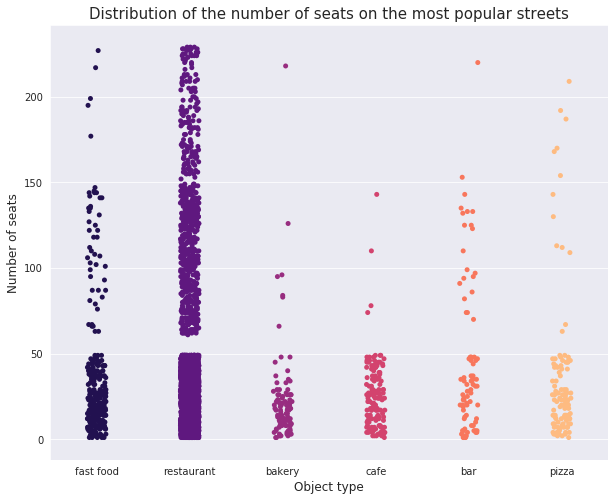

In [27]:
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.stripplot(x="object_type", y="number", data=top10_seats, palette='magma')
plt.title('Distribution of the number of seats on the most popular streets',fontdict={'size':15})    
plt.ylabel("Number of seats",fontdict={'size':12})
plt.xlabel("Object type",fontdict={'size':12})
plt.show()

The graph above shows the distribution of establishments by number of seats and type of establishment.
As we can see, the number of seats in most establishmentsvaries from 0 to 50. 
And I see a very interesting observation that in all types of establishments there is a gap between 50 and 60 seats, we can quite clearly see this feature in restaurant type establishments. It is also unusual to have establishments with a minimum number of seats, but if this is undersandable in such stablishents as fast food, pizza and bakery (since these astablishments often work with takeaway food), then as for restaurant, for example, it is hard for me to explain this feature. Perhaps this is due to incorrectly collected data.

As for the upper limit in terms of the number of seats, the clear leader is the type restaurant, where a fairly large number of establishments have more than 150 seats. Most likely this is due to the purpose of the restaurants, where customers come to enjoy the food and the atmosphere, usually they do not rush anywhere and spend a lot of time.

#### 2.6. Conclusion

In conclusion, I propose to choose the type of establishment and its location based on the research of the Los Angeles establishment market. To begin with, we will choose a location for opening uor establishment, as I believe that the correct placement is the key to success in the restaurant business. 
I propose to place the new robot cafe on one of the most popular and most visited streets in order to get a quick return on our investment - Sunset Boulevard. This street is long and crosses popular tourist areas such as Beverly Hills and Hollywood. It is the one of the most recognizable and famous streets in Los Angeles.

Robot cafe is a new trend that quickly captures the market, therefore, from the point of view of competitiveness, this idea is quite attractive. We need only to run an specific advertising campaign to attract new customers.

In the future, when the cafe buys most of the investments, I propose to make a chain of our robot cafes by focusing on popular streets and also make a detailed analysis of the streets with only one or few establishments. And if it will be need to open an additional one we can do it.

If we consider the type of establishment, I would choose to open a cafe with about 50 seats. As we can see in our research, this is a small segment in the Los Angeles establishment market and basically the number of seats in this type of establishment is about 25.
Thus, we will bring our cafes to a new level, it will be not only unique in terms of service methods, but also in terms of the establishment itself.

### Step 3. Preparing a presentation

#### Here is a presentation of my research to share with investors

Presentation: <link to cloud storage>

https://1drv.ms/p/s!Al1sIlAZhVX1kSSLdzpucEhrXUQH?e=SZz490


